In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import xesmf as xe

In [2]:
sst_ds = xr.open_dataset('../../data_1deg/CESM1LE_sst_NAtl_19200101_20051201.nc')['sst'][0:69,8:-16,:,:]
sss_ds = xr.open_dataset('../../data_1deg/CESM1LE_sss_NAtl_19200101_20051201.nc')['sss'][0:69,8:-32,:,:]
psl_ds = xr.open_dataset('../../data_1deg/CESM1LE_psl_NAtl_19200101_20051201.nc')['psl'][0:69,8:-32,:,:]

In [6]:
sst_deseason = (sst_ds.groupby('time.month') - sst_ds.groupby('time.month').mean('time')).groupby('time.year').mean('time')


/Users/peterw/miniconda3/envs/ml_env/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [12]:
sss_deseason = (sss_ds.groupby('time.month') - sss_ds.groupby('time.month').mean('time')).groupby('time.year').mean('time')



/Users/peterw/miniconda3/envs/ml_env/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [13]:
psl_deseason = (psl_ds.groupby('time.month') - psl_ds.groupby('time.month').mean('time')).groupby('time.year').mean('time')



In [18]:
landmask = np.isnan( sst_ds[:,:,0,0].values )

for ilat in range(len(psl_ds.lat)):
    for ilon in range(len(psl_ds.lon)):
        if landmask[ilat,ilon] == True:
            psl_deseason[ilat,ilon,:,:] = np.nan

In [25]:
sst_normalized = (sst_deseason - sst_deseason.mean())/sst_deseason.std()
sss_normalized = (sss_deseason - sss_deseason.mean())/sss_deseason.std()
psl_normalized = (psl_deseason - psl_deseason.mean())/psl_deseason.std()

In [26]:
lat = sst_ds.lat
lon = sst_ds.lon

lat_out = np.linspace(lat[0],lat[-1],244)
lon_out = np.linspace(lon[0],lon[-1],244)

In [27]:
ds_out = xr.Dataset({'lat': (['lat'], lat_out), 'lon': (['lon'], lon_out) })

In [33]:
regridder = xe.Regridder(sst_ds, ds_out, 'nearest_s2d')
regridder

xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_69x65_244x244.nc 
Reuse pre-computed weights? False 
Input grid shape:           (69, 65) 
Output grid shape:          (244, 244) 
Periodic in longitude?      False

In [36]:
sst_out = regridder( sst_normalized.transpose('ensemble','year','lat','lon') )

In [48]:
levels = np.arange(-2,2+0.1,0.1)

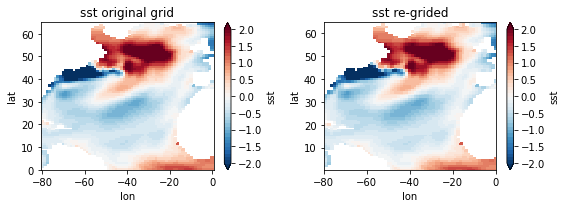

In [47]:
plt.figure(figsize=(8,3))

plt.subplot(121)
sst_normalized[:,:,0,0].plot(levels=levels)
plt.title('sst original grid')

plt.subplot(122)
sst_out[0,0,:,:].plot(levels=levels)
plt.title('sst re-grided')

plt.tight_layout()

In [40]:
sss_out = regridder( sss_normalized.transpose('ensemble','year','lat','lon') )

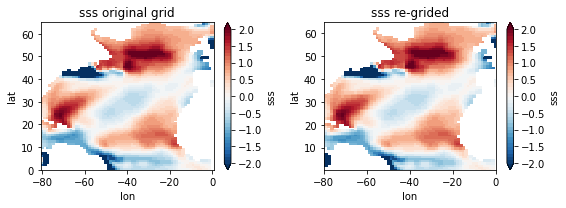

In [46]:
plt.figure(figsize=(8,3))

plt.subplot(121)
sss_normalized[:,:,0,0].plot(levels=levels)
plt.title('sss original grid')

plt.subplot(122)
sss_out[0,0,:,:].plot(levels=levels)
plt.title('sss re-grided')

plt.tight_layout()

In [42]:
psl_out = regridder( psl_normalized.transpose('ensemble','year','lat','lon') )

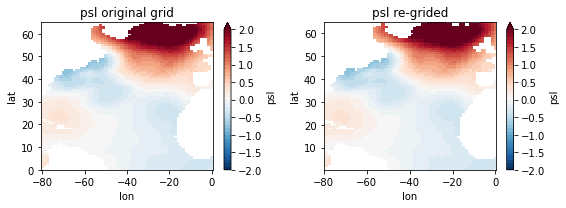

In [45]:
plt.figure(figsize=(8,3))

plt.subplot(121)
psl_normalized[:,:,0,0].plot(levels=levels)
plt.title('psl original grid')

plt.subplot(122)
psl_out[0,0,:,:].plot(levels=levels)
plt.title('psl re-grided')

plt.tight_layout()

In [71]:
amv_index = (np.cos(np.pi*sst_out.lat/180) * sst_out).mean(dim=('lat','lon'))

In [79]:
sst_out_values = sst_out.values
sss_out_values = sss_out.values
psl_out_values = psl_out.values

sst_out_values[np.isnan(sst_out_values)] = 0
sss_out_values[np.isnan(sss_out_values)] = 0
psl_out_values[np.isnan(psl_out_values)] = 0

In [89]:
psl_out_values.shape

(42, 86, 244, 244)

In [102]:
amv_index.shape

(42, 86)

In [111]:
sst_out_values.shape

(42, 86, 244, 244)

In [112]:
data_out = np.array([sst_out_values[0:40,:,:,:],sss_out_values[0:40,:,:,:],psl_out_values[0:40,:,:,:]])

In [113]:
data_out.shape

(3, 40, 86, 244, 244)

In [114]:
np.save('CESM_data_sst_sss_psl_deseason_normalized_resized.npy',data_out)

In [117]:
np.save('CESM_label_amv_index.npy',amv_index[0:40,:])